In [1]:
#%%
import sys
sys.path.insert(0, "..")

#%%
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from notebooks.utils.mpc_utils import (
    compute_new_pose,
    poses_to_diff
)

#%%
# Initialize VJEPA 2-AC model
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")

Using cache found in /home/yinzi/.cache/torch/hub/facebookresearch_vjepa2_main
/nvmessd/yinzi/vjepa2/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:

# 移动模型到GPU
# device = "cpu"
device = "cuda:2"
encoder = encoder.to(device)
predictor = predictor.to(device)
print(f"Models moved to {device}")
print(f"Encoder device: {next(encoder.parameters()).device}")
print(f"Predictor device: {next(predictor.parameters()).device}")

# Initialize transform
crop_size = 256
tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)
print(f"tokens_per_frame: {tokens_per_frame}")

Models moved to cuda:2
Encoder device: cuda:2
Predictor device: cuda:2
tokens_per_frame: 256


In [15]:
# Load robot trajectory

play_in_reverse = False  # Use this FLAG to try loading the trajectory backwards, and see how the energy landscape changes

trajectory = np.load("notebooks/franka_example_traj.npz")
np_clips = trajectory["observations"]
np_states = trajectory["states"]
if play_in_reverse:
    np_clips = trajectory["observations"][:, ::-1].copy()
    np_states = trajectory["states"][:, ::-1].copy()
np_actions = np.expand_dims(poses_to_diff(np_states[0, 0], np_states[0, 1]), axis=(0, 1))
# Convert trajectory to torch tensors
clips = transform(np_clips[0]).unsqueeze(0).to(device)
states = torch.tensor(np_states, dtype=torch.float32).to(device)
actions = torch.tensor(np_actions, dtype=torch.float32).to(device)
print(f"clips: {clips.shape}; states: {states.shape}; actions: {actions.shape}")
print(f"clips device: {clips.device}")
print(f"states device: {states.device}")

clips: torch.Size([1, 3, 2, 256, 256]); states: torch.Size([1, 2, 7]); actions: torch.Size([1, 1, 7])
clips device: cuda:2
states device: cuda:2


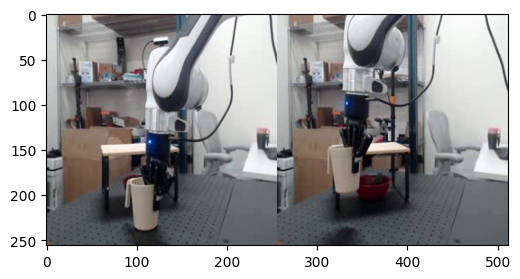

In [16]:
# Visualize loaded video frames from traj

T = len(np_clips[0])
plt.figure(figsize=(20, 3))
_ = plt.imshow(np.transpose(np_clips[0], (1, 0, 2, 3)).reshape(256, 256 * T, 3))

In [17]:
np_clips.shape

(1, 2, 256, 256, 3)

In [18]:
def forward_target(c, normalize_reps=True):
    # ([1, 3, 2, 256, 256]); 
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

In [19]:
with torch.no_grad():
    h = forward_target(clips)

    h_hat = h[:, :tokens_per_frame]  # [1, N, D]
    s_hat = states[:, :1] # [1, 1, 7]
    a_hat = actions  # [1, 1, 7]
    _h = predictor(h_hat, a_hat, s_hat)[:, -tokens_per_frame:]

In [20]:
_h.shape

torch.Size([1, 256, 1408])

In [21]:
#%%
from pathlib import Path
from src.models.vjepa2_decoder import VJEPA2FrameDecoder

decoder_checkpoint_path = Path("/nvmessd/yinzi/vjepa2/checkpoints/decoder_train_vitg/e100.pt")
if not decoder_checkpoint_path.exists():
    raise FileNotFoundError(f"Missing decoder checkpoint at {decoder_checkpoint_path}")

decoder_checkpoint = torch.load(decoder_checkpoint_path, map_location="cuda:3")
decoder_state_dict = decoder_checkpoint.get("decoder", decoder_checkpoint)

def infer_frame_decoder_config(state_dict, default_embed_dim=1024, default_depth=24):
    decoder_embed_param = state_dict.get("norm.weight")
    decoder_embed_dim = (
        decoder_embed_param.shape[0] if decoder_embed_param is not None else default_embed_dim
    )
    layer_ids = []
    prefix = "transformer.layers."
    for key in state_dict.keys():
        if key.startswith(prefix):
            parts = key.split(".")
            if len(parts) > 2:
                try:
                    layer_ids.append(int(parts[2]))
                except ValueError:
                    continue
    decoder_depth = max(layer_ids) + 1 if layer_ids else default_depth
    return decoder_embed_dim, decoder_depth


decoder_embed_dim, decoder_depth = infer_frame_decoder_config(decoder_state_dict)
decoder_token_dim = _h.size(-1)
decoder_model = VJEPA2FrameDecoder(
    encoder_dim=decoder_token_dim,
    image_size=crop_size,
    patch_size=encoder.patch_size,
    tubelet_size=getattr(encoder, "tubelet_size", 1),
    channels=3,
    decoder_embed_dim=decoder_embed_dim,
    depth=decoder_depth,
    num_heads=16,
).to(device)
load_msg = decoder_model.load_state_dict(decoder_state_dict, strict=False)
print(f"Decoder checkpoint -> embed_dim={decoder_embed_dim}, depth={decoder_depth}")
print(load_msg)
decoder_model = decoder_model.eval()

IMAGE_MEAN_255 = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=device).view(1, 3, 1, 1, 1) * 255.0
IMAGE_STD_255 = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=device).view(1, 3, 1, 1, 1) * 255.0

Decoder checkpoint -> embed_dim=1408, depth=40
<All keys matched successfully>


Next-frame pixel MSE: 2621.26


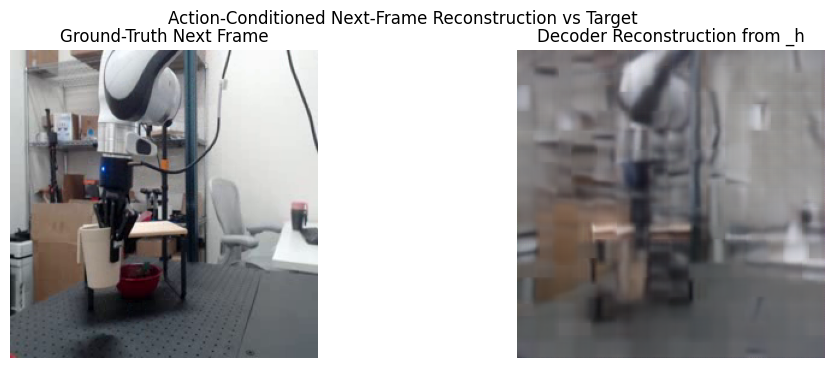

In [22]:
#%%
pred_frame_idx = 0
next_frame_idx = -1
gt_next_frame = np_clips[0, next_frame_idx]
gt_next_frame_float = gt_next_frame.astype(np.float32)
with torch.no_grad():
    reconstructed_clip = decoder_model(_h)
decoded_pixels = (reconstructed_clip * IMAGE_STD_255) + IMAGE_MEAN_255
decoded_pixels = decoded_pixels.clamp(0.0, 255.0)
pred_frame_idx = min(pred_frame_idx, decoded_pixels.size(2) - 1)
decoded_next_frame = (
    decoded_pixels[:, :, pred_frame_idx]
    .squeeze(0)
    .permute(1, 2, 0)
    .cpu()
    .numpy()
)
decoded_next_frame_uint8 = decoded_next_frame.clip(0, 255).astype(np.uint8)
frame_mse = np.mean((decoded_next_frame - gt_next_frame_float) ** 2)
print(f"Next-frame pixel MSE: {frame_mse:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(gt_next_frame)
axes[0].set_title("Ground-Truth Next Frame")
axes[0].axis("off")

axes[1].imshow(decoded_next_frame_uint8)
axes[1].set_title("Decoder Reconstruction from _h")
axes[1].axis("off")

plt.suptitle("Action-Conditioned Next-Frame Reconstruction vs Target")
plt.show()

In [11]:
# Load Door Unity3D dataset sample clip

from pathlib import Path
import imageio.v2 as imageio
import numpy as np

# Configure which frames to grab
# Update the parameters below to sample any span of frames you care about.
door_requested_start = 0        # starting frame index within the episode video
door_num_frames = 4             # how many frames to pull (must be >= 2)
door_frame_stride = 1           # gap between frames; 1 == consecutive, 2 == every other, etc.

if door_num_frames < 2:
    raise ValueError("Need at least two frames to compare")
if door_frame_stride < 1:
    raise ValueError("door_frame_stride must be >= 1")

door_requested_indices = [
    int(door_requested_start + i * door_frame_stride)
    for i in range(door_num_frames)
]

door_dataset_root = Path("/nvmessd/yinzi/vjepa2/datasets/door_unity3d_collected_data")
door_episode_name = "episode_0001_20250818_150946"
door_video_path = door_dataset_root / door_episode_name / "recordings/MP4/nav_camera.mp4"

if not door_video_path.exists():
    raise FileNotFoundError(f"Missing video at {door_video_path}")

reader = imageio.get_reader(door_video_path)
door_frames = []
door_frame_indices = []
try:
    total_frames = reader.count_frames()
except Exception:
    total_frames = None

if total_frames is not None and total_frames > 0:
    max_requested = door_requested_indices[-1]
    if max_requested >= total_frames:
        raise ValueError(
            f"Requested frame {max_requested} is outside the available range 0-{total_frames - 1}"
        )
    for idx in door_requested_indices:
        frame = reader.get_data(int(idx))
        door_frames.append(frame)
        door_frame_indices.append(int(idx))
else:
    target_iter = iter(door_requested_indices)
    next_target = next(target_iter)
    for idx, frame in enumerate(reader):
        if idx < next_target:
            continue
        if idx == next_target:
            door_frames.append(frame)
            door_frame_indices.append(idx)
            try:
                next_target = next(target_iter)
            except StopIteration:
                break

reader.close()

if len(door_frames) < door_num_frames:
    raise RuntimeError(
        f"Only collected {len(door_frames)} frames from {door_video_path} starting at index {door_requested_start}"
    )

door_np_clip = np.stack(door_frames, axis=0)
door_clips = transform(door_np_clip).unsqueeze(0).to(device)

print(f"door_np_clip: {door_np_clip.shape}; door_clips: {door_clips.shape}")
print(f"door_frame_indices: {door_frame_indices}")

door_np_clip: (4, 84, 84, 3); door_clips: torch.Size([1, 3, 4, 256, 256])
door_frame_indices: [0, 1, 2, 3]


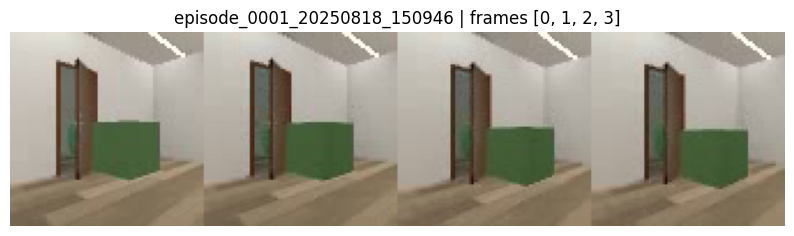

In [12]:
# Visualize sample video frames from Door Unity3D dataset

door_T, door_H, door_W = door_np_clip.shape[:3]
plt.figure(figsize=(10, 3))
_ = plt.imshow(np.transpose(door_np_clip, (1, 0, 2, 3)).reshape(door_H, door_W * door_T, 3))
plt.title(f"{door_episode_name} | frames {door_frame_indices}")
plt.axis("off")
plt.show()


Frame -> [x y z rx ry rz] | gripper
0000 -> [+0.000 +0.000 +0.000 +0.000 +0.000 +0.000] | grip=+0.000
0003 -> [+0.100 +0.100 +0.000 +0.000 +0.000 +0.000] | grip=+0.000
0006 -> [+0.100 +0.100 +0.000 +0.000 +0.000 +0.100] | grip=+0.000
0009 -> [+0.090 +0.200 +0.000 +0.000 +0.000 +0.100] | grip=+0.000
Approximate cartesian deltas (end - start) per step:
0→3: [+0.1000 +0.1000 +0.0000 +0.0000 +0.0000 +0.0000] | Δgrip=+0.0000 | action≈→
3→6: [+0.0000 +0.0000 +0.0000 +0.0000 +0.0000 +0.1000] | Δgrip=+0.0000 | action≈· (静止)
6→9: [-0.0100 +0.0995 +0.0000 +0.0000 +0.0000 +0.0000] | Δgrip=+0.0000 | action≈↑


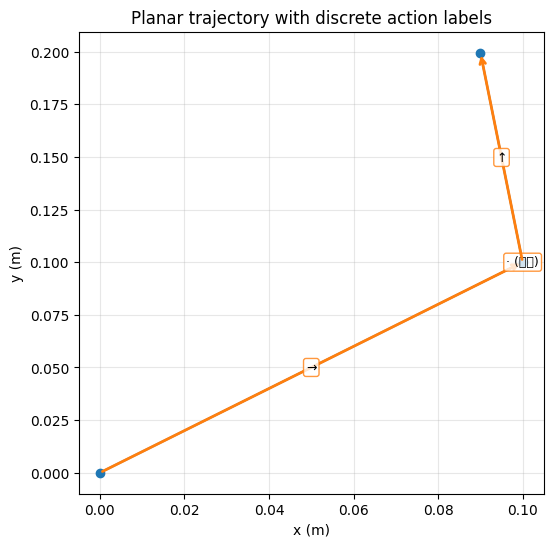

In [47]:
# Summarize robot state deltas for the sampled frames

import h5py

door_traj_path = door_dataset_root / door_episode_name / "trajectory.h5"
if not door_traj_path.exists():
    raise FileNotFoundError(f"Missing trajectory at {door_traj_path}")

with h5py.File(door_traj_path, "r") as traj_file:
    door_cartesian = traj_file["observation/robot_state/cartesian_position"][door_frame_indices]
    door_gripper = traj_file["observation/robot_state/gripper_position"][door_frame_indices]

print("Frame -> [x y z rx ry rz] | gripper")
for frame_idx, pose, grip in zip(door_frame_indices, door_cartesian, door_gripper):
    pose_str = " ".join(f"{value:+.3f}" for value in pose)
    print(f"{frame_idx:04d} -> [{pose_str}] | grip={grip:+.3f}")

if len(door_frame_indices) >= 2:
    door_action_deltas = np.diff(door_cartesian, axis=0)
    door_gripper_deltas = np.diff(door_gripper, axis=0)
    step_labels = [f"{door_frame_indices[i]}→{door_frame_indices[i + 1]}" for i in range(len(door_action_deltas))]

    door_axis_label_lookup = {
        ("x", "positive"): "→",
        ("x", "negative"): "←",
        ("y", "positive"): "↑",
        ("y", "negative"): "↓",
        ("z", "positive"): "⇑",
        ("z", "negative"): "⇓",
    }

    def label_discrete_action(delta, threshold=1e-4):
        translation = delta[:3]
        if np.all(np.abs(translation) < threshold):
            return "· (静止)"
        major_axis = int(np.argmax(np.abs(translation)))
        magnitude = translation[major_axis]
        axis_name = ["x", "y", "z"][major_axis]
        direction = "positive" if magnitude >= 0 else "negative"
        return door_axis_label_lookup.get((axis_name, direction), f"{axis_name}_{direction}")

    door_discrete_labels = [label_discrete_action(delta) for delta in door_action_deltas]

    print("Approximate cartesian deltas (end - start) per step:")
    for label, delta, grip_delta, discrete_label in zip(step_labels, door_action_deltas, door_gripper_deltas, door_discrete_labels):
        delta_str = " ".join(f"{value:+.4f}" for value in delta)
        print(f"{label}: [{delta_str}] | Δgrip={grip_delta:+.4f} | action≈{discrete_label}")


    # Simple planar visualization of discrete actions
    planar_xy = door_cartesian[:, :2]
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.plot(planar_xy[:, 0], planar_xy[:, 1], color='tab:blue', marker='o')
    for i, discrete_label in enumerate(door_discrete_labels):
        start = planar_xy[i]
        end = planar_xy[i + 1]
        ax2.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(arrowstyle="->", color='tab:orange', linewidth=2)
        )
        mid = (start + end) / 2.0
        ax2.text(
            mid[0],
            mid[1],
            discrete_label,
            ha='center',
            va='center',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='tab:orange', alpha=0.8)
        )
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    ax2.set_title('Planar trajectory with discrete action labels')
    ax2.grid(True, alpha=0.3)
else:
    print("Need at least two frames to compute action deltas; increase door_num_frames.")


In [ ]:
# Visualize sampled frames with action arrows overlayed on each step

if len(door_frame_indices) < 2:
    print("Need at least two frames to visualize actions; increase door_num_frames.")
elif 'door_action_deltas' not in globals():
    raise RuntimeError("Run the action summary cell above first to compute door_action_deltas.")
else:
    door_step_labels = [
        f"{door_frame_indices[i]}→{door_frame_indices[i + 1]}"
        for i in range(len(door_frame_indices) - 1)
    ]
    num_steps = len(door_step_labels)

    fig, axes = plt.subplots(1, num_steps, figsize=(4 * num_steps, 4))
    if num_steps == 1:
        axes = [axes]

    image_height, image_width = door_np_clip.shape[1:3]
    arrow_scale = min(image_height, image_width) * 0.25

    for idx, ax in enumerate(axes):
        ax.imshow(door_np_clip[idx])
        ax.axis("off")
        ax.set_title(door_step_labels[idx])

        delta_xy = door_action_deltas[idx][:2]
        norm = np.linalg.norm(delta_xy)
        if norm > 1e-6:
            direction = delta_xy / (np.max(np.abs(delta_xy)) + 1e-8)
            arrow_vec = direction * arrow_scale
            start = np.array([image_width / 2.0, image_height / 2.0])
            end = start + np.array([arrow_vec[0], -arrow_vec[1]])
            ax.annotate(
                "",
                xy=end,
                xytext=start,
                arrowprops=dict(arrowstyle="->", color='yellow', linewidth=2)
            )

        if 'door_discrete_labels' in globals():
            label = door_discrete_labels[idx]
            ax.text(
                8,
                18,
                label,
                color='yellow',
                fontsize=12,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', fc='black', ec='yellow', alpha=0.7)
            )

    plt.suptitle('Per-frame actions overlayed as arrows')
    plt.tight_layout()


Dataset root: /nvmessd/yinzi/vjepa2/datasets/dreamer_empty_unity
Total episodes: 1001


,episode,length,reward,door_touches,first_actions
0,episode_0001_20251109_152246,112,1.0,0,"[6, 5, 5, 5, 5]"
1,episode_0002_20251109_152250,70,1.0,0,"[4, 0, 0, 0, 6]"
2,episode_0003_20251109_152252,63,1.0,0,"[5, 5, 5, 5, 5]"



Sample episode video preview:
Episode: episode_0001_20251109_152246
Video path: /nvmessd/yinzi/vjepa2/datasets/dreamer_empty_unity/episode_0001_20251109_152246/recordings/MP4/episode_camera.mp4


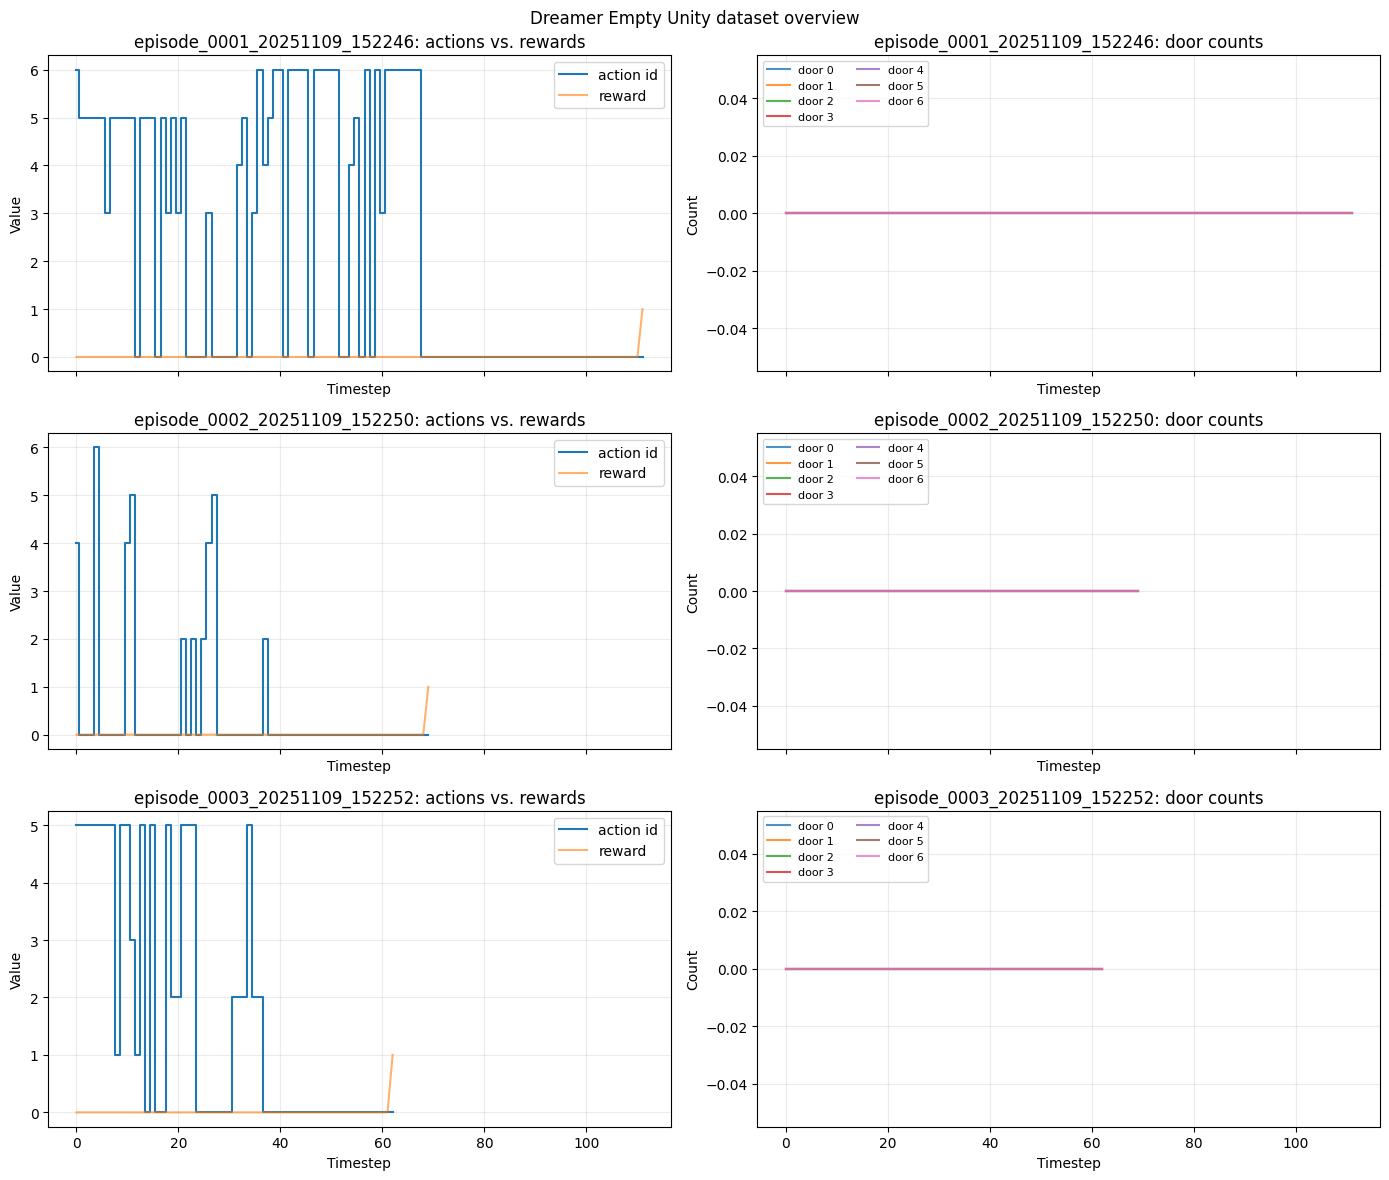

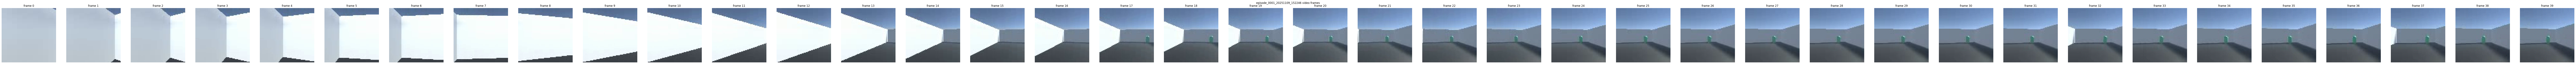

In [4]:
#%%
# Preview Dreamer Empty Unity dataset
from pathlib import Path
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt

try:
    import imageio.v2 as imageio
except ImportError:  # pragma: no cover
    imageio = None

try:
    import ipywidgets as widgets  # type: ignore
except ImportError:  # pragma: no cover
    widgets = None

try:
    from IPython.display import display as ipy_display, clear_output as ipy_clear_output
except ImportError:  # pragma: no cover
    ipy_display = None
    ipy_clear_output = None


dataset_root = Path("/nvmessd/yinzi/vjepa2/datasets/dreamer_empty_unity")
episode_dirs = sorted(dataset_root.glob("episode_*"))
if not episode_dirs:
    raise RuntimeError(f"No episodes found in {dataset_root}")

print(f"Dataset root: {dataset_root}")
print(f"Total episodes: {len(episode_dirs)}")


def load_episode_contents(ep_dir):
    metadata = json.loads(ep_dir.joinpath("metadata.json").read_text())
    with h5py.File(ep_dir / "trajectory.h5", "r") as f:
        actions = f["episode"]["actions"][:]
        rewards = f["episode"]["rewards"][:]
        door_counts = f["episode"]["door_counts"][:]
    return metadata, actions, rewards, door_counts


max_episodes_to_show = 3
episode_summaries = []
timeseries = []
for ep_dir in episode_dirs[:max_episodes_to_show]:
    metadata, actions, rewards, door_counts = load_episode_contents(ep_dir)
    episode_summaries.append(
        {
            "episode": metadata.get("episode_name", ep_dir.name),
            "length": int(metadata.get("episode_length", len(actions))),
            "reward": float(metadata.get("episode_reward", 0.0)),
            "door_touches": int(metadata.get("total_door_touches", 0)),
            "first_actions": actions[:5].tolist(),
        }
    )
    timeseries.append(
        (
            metadata.get("episode_name", ep_dir.name),
            actions,
            rewards,
            door_counts,
        )
    )

try:
    import pandas as pd  # type: ignore
except ImportError:  # pragma: no cover
    pd = None

if pd is not None and ipy_display is not None:
    ipy_display(pd.DataFrame(episode_summaries))
else:
    from pprint import pprint

    pprint(episode_summaries)

if not timeseries:
    raise RuntimeError("No episode summaries available to visualize")

num_rows = len(timeseries)
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows), sharex="col")
if num_rows == 1:
    axes = axes[np.newaxis, :]

for idx, (name, actions, rewards, door_counts) in enumerate(timeseries):
    steps = np.arange(actions.shape[0])
    axes[idx, 0].step(steps, actions, where="mid", label="action id")
    axes[idx, 0].plot(steps, rewards, color="tab:orange", alpha=0.6, label="reward")
    axes[idx, 0].set_ylabel("Value")
    axes[idx, 0].set_xlabel("Timestep")
    axes[idx, 0].set_title(f"{name}: actions vs. rewards")
    axes[idx, 0].grid(True, alpha=0.25)
    axes[idx, 0].legend(loc="upper right")

    if door_counts.ndim == 2:
        for door_idx in range(door_counts.shape[1]):
            axes[idx, 1].plot(
                steps,
                door_counts[:, door_idx],
                label=f"door {door_idx}",
                alpha=0.8,
            )
    else:
        axes[idx, 1].plot(steps, door_counts, label="door counts", alpha=0.8)
    axes[idx, 1].set_ylabel("Count")
    axes[idx, 1].set_xlabel("Timestep")
    axes[idx, 1].set_title(f"{name}: door counts")
    axes[idx, 1].grid(True, alpha=0.25)
    axes[idx, 1].legend(loc="upper left", ncol=2, fontsize=8)

fig.suptitle("Dreamer Empty Unity dataset overview")
fig.tight_layout()
plt.show()

sample_episode_dir = episode_dirs[0]
sample_metadata_path = sample_episode_dir / "metadata.json"
sample_metadata = json.loads(sample_metadata_path.read_text())
sample_video_rel = sample_metadata.get("video_path", "recordings/MP4/episode_camera.mp4")
sample_video_path = sample_episode_dir / sample_video_rel
print("
Sample episode video preview:")
print(f"Episode: {sample_metadata.get('episode_name', sample_episode_dir.name)}")
print(f"Video path: {sample_video_path}")
if not sample_video_path.exists():
    print(f"Video file not found: {sample_video_path}")
elif imageio is None:
    print("Install imageio (e.g., pip install imageio[pyav]) to preview video frames.")
else:
    try:
        base_reader = imageio.get_reader(sample_video_path)
    except Exception as err:  # pragma: no cover
        print(f"Failed to open video: {err}")
    else:
        try:
            total_frames = base_reader.count_frames()
        except Exception:
            total_frames = None
        base_reader.close()

        frames_to_show = 6

        def show_sample_frames(start_frame=30):
            with imageio.get_reader(sample_video_path) as reader:
                start_idx = max(0, int(start_frame))
                if total_frames is not None and total_frames > 0:
                    start_idx = min(start_idx, max(total_frames - frames_to_show, 0))
                sampled_frames = []
                for frame_idx in range(start_idx, start_idx + frames_to_show):
                    try:
                        frame = reader.get_data(frame_idx)
                    except Exception:
                        break
                    sampled_frames.append((frame_idx, frame))

            if not sampled_frames:
                print(f"No frames decoded starting from t={start_idx}.")
                return

            fig_frames, axes_frames = plt.subplots(
                1, len(sampled_frames), figsize=(4 * len(sampled_frames), 4)
            )
            if len(sampled_frames) == 1:
                axes_frames = [axes_frames]
            for ax, (frame_idx, frame) in zip(axes_frames, sampled_frames):
                ax.imshow(frame)
                ax.axis("off")
                ax.set_title(f"frame {frame_idx}")
            first_frame_label = sampled_frames[0][0]
            fig_frames.suptitle(
                f"{sample_metadata.get('episode_name', sample_episode_dir.name)} video frames (t≥{first_frame_label})"
            )
            fig_frames.tight_layout()
            plt.show()

        if total_frames is None or total_frames <= 0:
            print("Video length unavailable; showing frames starting at t=30 by default.")
            show_sample_frames(start_frame=30)
        elif widgets is None or ipy_display is None or ipy_clear_output is None:
            if widgets is None:
                print("ipywidgets not installed; showing static preview from t=30.")
            show_sample_frames(start_frame=30)
        else:
            slider = widgets.IntSlider(
                min=0,
                max=max(total_frames - frames_to_show, 0),
                value=min(30, max(total_frames - frames_to_show, 0)),
                description="start t",
                continuous_update=False,
            )
            output = widgets.Output()
            ipy_display(widgets.VBox([slider]), output)

            def on_slider_change(change):
                if change.get('name') == 'value':
                    with output:
                        ipy_clear_output(wait=True)
                        show_sample_frames(start_frame=change['new'])

            slider.observe(on_slider_change, names='value')

            with output:
                show_sample_frames(start_frame=slider.value)
